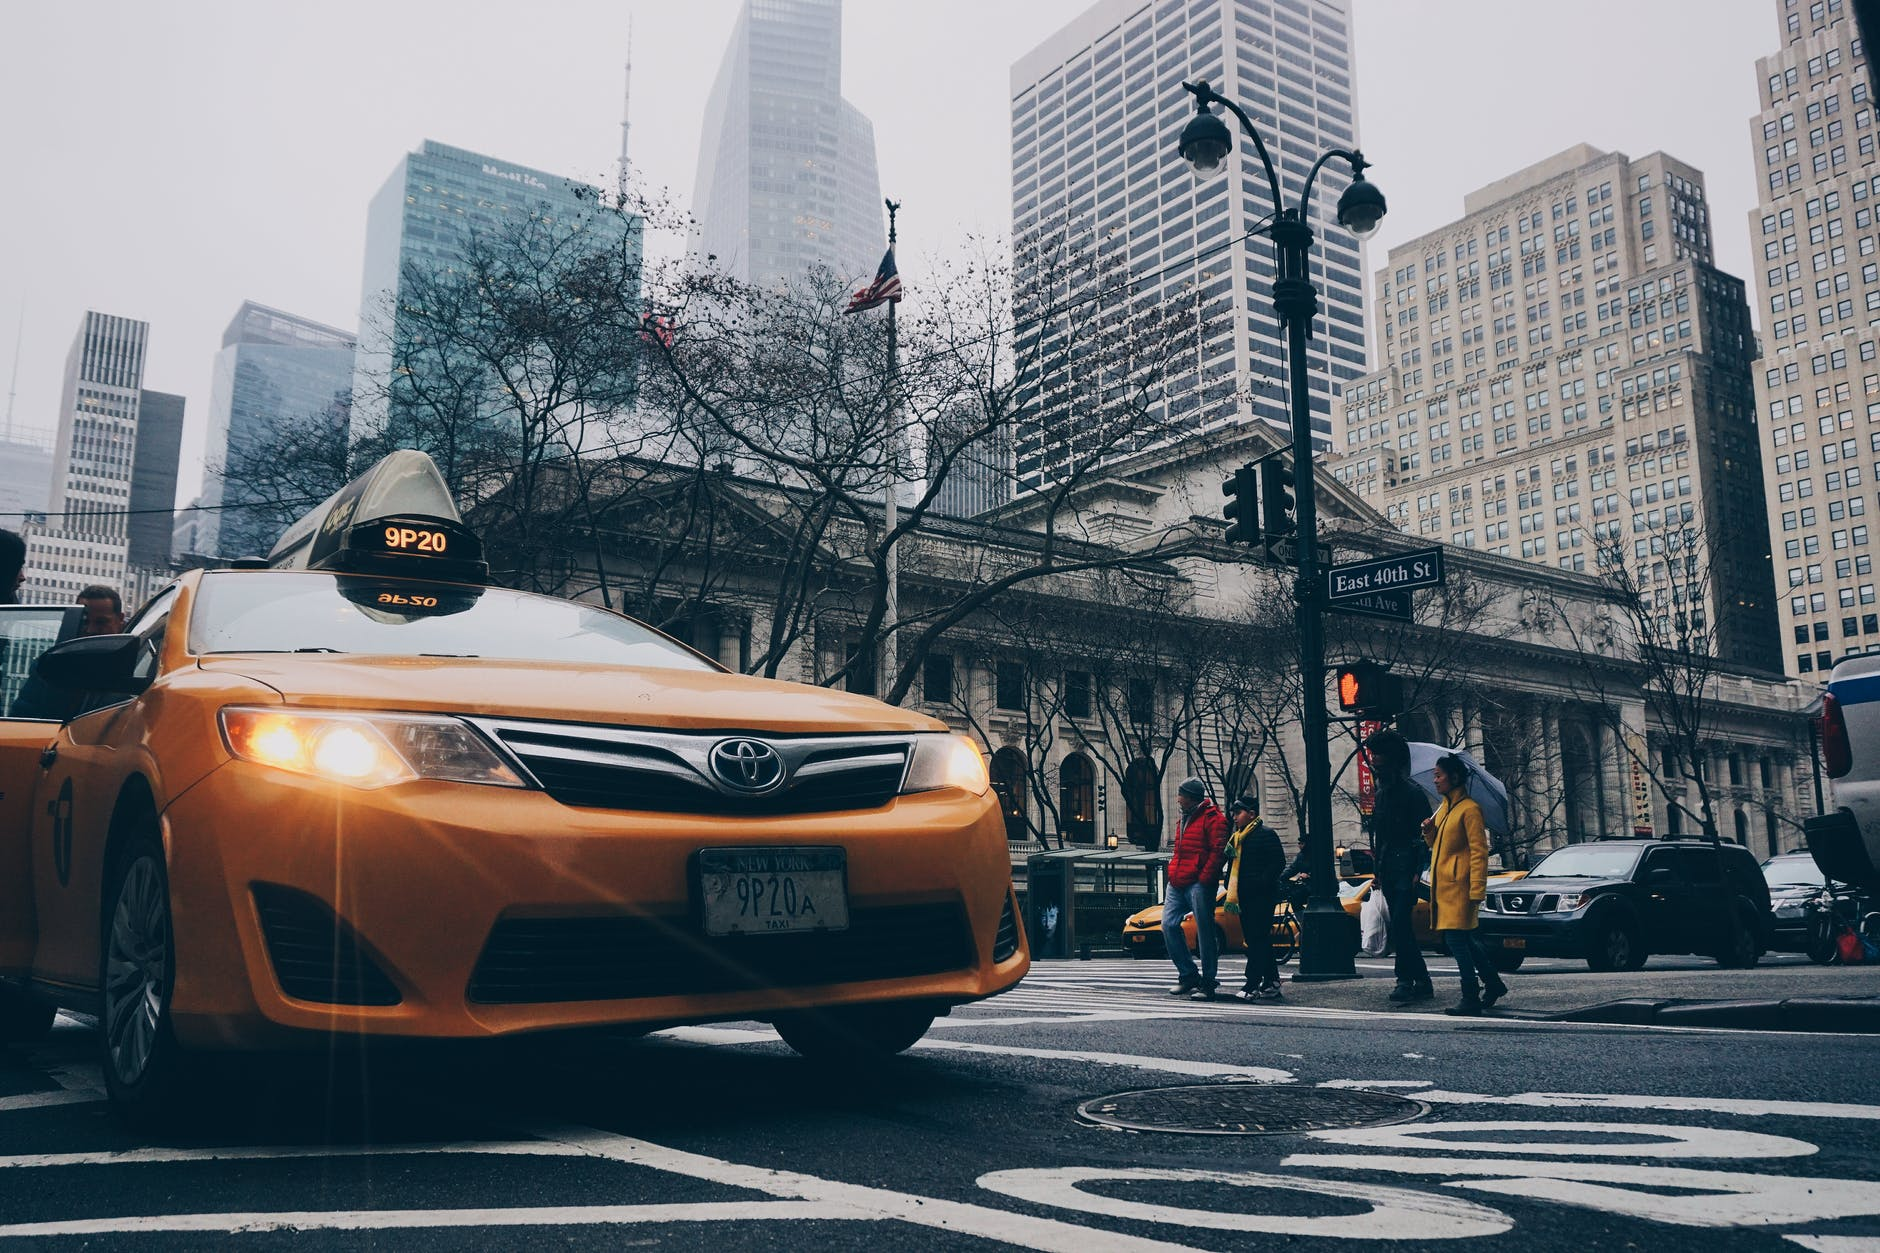

# **1. Introdução**

As técnicas de aprendizagem de máquina atualmente são largamente utilizadas para a resolução de problemas complexos. Dizemos que um agente inteligente (representado por um algoritmo computacional) está aprendendo se ele melhora a sua perfomance em tarefas futuras após realizar observações em seu universo. Uma dessas técnicas é particularmente interessante: a partir de uma coleção de entradas e saídas (x,y), o agente deve aprender uma função f(x) = y que prevê a saída para novas entradas. Esse procedimento é conhecido como aprendizagem supervisionada.

Nem sempre é possível sabermos se tal função f(x) realmente existe e, se existe, nem sempre é possível prevê-la (fatores como esforço computacional podem impedir isso). Assim, a aprendizagem supervisionada geralmente é focada em encontrar uma função de hipótese h(x) que se aproxima o máximo possível da função f(x).

Dentro desse contexto, podemos utilizar tal técnica para a resolução de problemas de previsão e de classificação de variáveis. Este trabalho realiza uma tarefa de previsão e é voltado para a determinação de tarifas de corridas de taxis na cidade de Nova Iorque. Podemos imaginar que as tarifas desse serviço seguem uma função que de fato existe e que não deve ser muito complexa. De fato, a função que rege o preço das corridas de taxi pode ser encontrada em ([*NY Taxi Rides*](https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page)) e os principais pontos são descritos a seguir:
* Taxa inicial de \$2.50
* Acréscimo de \$0.50 a cada 1/5 de milha  ou a cada 60 segundos
* Acréscimo de \$0.50 para viagens que acabam em lugares selecionados
* Acréscimo de \$0.30 para viagens com melhorias
* Acréscimo de \$0.50 para viagens entre 8pm e 6am
* Acréscimo de \$1.00 para viagens na hora do rush
* Pagamento dos pedágios por conta dos passaegiros
* Não há acrescimo pelo número de passageiros

Desse modo, devemos extrair do conjunto de dados fornecido pelo Kaggle ([*Taxi Fares*](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview)) *features* que expressam os pontos levantados acima para que possamos utilizar modelos de aprendizagem capazes de prever o preço das corridas finais. Este documento possui a seguinte organização: esta seção traz uma breve introdução ao tema; a seção 2 realiza a importação dos conjuntos de dados de treino e de teste, bem como uma breve visualização dos dados e o tratamento inicial; na seção 3 todas as variáveis de são tratadas de modo a extrair *features* para a previsão; a seção 4 apresenta a visualização dos *insights* e, por fim, a seção 5 apresenta o treinamento do modelo. 

# **2. Importação e Tratamento Inicial dos Dados**

**2.1 Importação dos dados de treino e de teste**

Primeiramente, importabos as bibliotecas necessárias e os conjuntos de treinamento e de teste

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

start_time = time.time()
X = pd.read_csv('../input/new-york-city-taxi-fare-prediction/train.csv', nrows = 3_000_000)
X_test = pd.read_csv('../input/new-york-city-taxi-fare-prediction/test.csv')
X.head()

**2.2 Descrição geral dos dados**

In [ ]:
X.info()

Podemos observar que o conjunto possui basicamente 6 features, que descrevem a data de início da corrida, as coordenadas de início e de fim da viagem e a quantidade de passageiros transportados. A variável alvo é o valor da corrida.

Podemos perceber, também, que existem alguns valores faltantes, contudo, não são significativos. Na próxima subseção, as linhas com valores faltantes serão retiradas do conjunto de dados.

Em seguida, podemos realizar o levantamento estatístico das variáveis

In [ ]:
X.describe()

A partir do levantamento estatístico, podemos perceber que existem outliers em todas as variáveis do conjunto, já que os valores máximos são bastante diferentes do *percentile* de 75%. Na seção 3, realizaremos tal tratamento.

In [ ]:
# Correlação das variáveis
correlation = X.corr()

plt.figure(figsize=(8,8))
sns.heatmap(correlation, annot = True)
plt.title('Correlação das Variáveis')

plt.show()

Observando a primeira linha do *heatmap* de correlações, podemos perceber que não há uma forte correlação entre as variáveis iniciais e o preço da corrida final. Isso é esperado, já que nem coordenadas geográficas nem data de início da viagem necessariamente expressam as regras descritas na introdução deste documento.

**2.3 Tratamento inicial do conjunto**

Realizamos a remoção dos dados faltantes do conjunto

In [ ]:
missing_val_count_by_column = (X.isnull().sum())
print('Features com dados faltantes no DataSet:')
print(missing_val_count_by_column[missing_val_count_by_column > 0])


qtd_inicial, _ = X.shape
print('Retirando linhas que possuem valores faltantes')
X.dropna(inplace=True)
qtd_final, _ = X.shape
print('Porcentagem de dados retirados do conjunto: {:.02f}%'.format((1 - qtd_final/qtd_inicial)*100))



# **3. Pré-Processamento das Variáveis**

Esta é uma das seções mais importantes do trabalho. Aqui utilizaremos as técnicas de *feature generation*, tratamento *outliers*, *clusterização* para tranformas as variáveis de entrada em *features* valiosas para que os modelos possam prever adequadamente o preço das corridas de taxi. As subseções a seguir tratam cada variável independentemente. As principais visualizações de dados é realizada na seção 4.

**3.1 Pré-Processamento da label (preço das corridas)**

Primeiramente, podemos identificar os *outliers* na label. Preços de corridas exorbitantes ou negativos provavelmente são devidos à erros na entrada. Esses valores atrapalham o processo de aprendizagem dos modelos e, portanto, devem ser retirados do conjunto. 

In [ ]:
fig, ((ax1,ax2)) = plt.subplots(figsize = [14,6],nrows = 1, ncols = 2)
plt.subplots_adjust(left=0, bottom=None, right=1, top=0.5, wspace = 0.8, hspace=None)
sns.set(style="darkgrid")

ax1.boxplot(X['fare_amount'])
ax1.set_title('Boxplot - Preço das corridas')


sns.distplot(a=X['fare_amount'], kde=False)
ax2.set_title('Distribuição do preço das corridas')
ax2.set_xlabel('Preço')
ax2.set_ylabel('Quantidade')


plt.tight_layout()
plt.show()

Em seguida, retiramos os valores inválidos do conjunto.

In [ ]:
def clean_fare_amount(df):
    return df[(df.fare_amount > 0) & (df.fare_amount < 200)]
qtd_inicial, _ = X.shape
X = clean_fare_amount(X)

print('Retirando linhas que possuem preços inválidos')
qtd_final, _ = X.shape
print('Porcentagem de dados retirados do conjunto: {:.02f}%'.format((1 - qtd_final/qtd_inicial)*100))


**3.2 Pré-Processamento das coordenadas geográficas**

As variáveis de localização são particularmente importantes para a previsão das tarifas. Daqui poderemos extrair, de forma aproximada, a distância da viagem de taxi, que é umas das coisas que mais afetam o preço da viagem. Poderemos extrair, também, a zona de partida e de destino, que também impactam fortemente o preço. Assim como foi feito com a label, devemos, inicialmente, retirar os *outliers* que atrapalham a capacidade de previsão dos modelos.

**3.2.1 Visualização e retirada dos *outliers***



In [ ]:
# Verificando os outliers nas longitudes e latitudes
fig, (ax1,ax2) = plt.subplots(figsize = [14, 6],nrows = 1, ncols = 2)

ax1.boxplot(X['pickup_latitude'])
ax2.boxplot(X['pickup_longitude'])

ax1.set_title('Latitude de partida')
ax2.set_title('Longitude de partida')

ax1.set_ylabel('Latitude')
ax2.set_ylabel('Longitude')


fig.show()

A latitude da cidade de Nova Iorque é 40.730610 e a longitude é -73.935242. Conforme podemos ver pelos boxplots, existem valores muito diferentes disso, tanto na partida quanto no destino. A função a seguir foi adaptada de https://www.kaggle.com/gunbl4d3/xgboost-ing-taxi-fares e realiza a retirada de valores discrepantes.

In [ ]:
def clean_locations(df):
    return df[
            (df.pickup_longitude > -80) & (df.pickup_longitude < -70) &
            (df.pickup_latitude > 35) & (df.pickup_latitude < 45) &
            (df.dropoff_longitude > -80) & (df.dropoff_longitude < -70) &
            (df.dropoff_latitude > 35) & (df.dropoff_latitude < 45) 
            ]


In [ ]:
qtd_inicial, _ = X.shape
print('Retirando linhas que possuem localizações inválidas')
X = clean_locations(X)
qtd_final, _ = X.shape
print('Porcentagem de dados retirados do conjunto: {:.02f}%'.format((1 - qtd_final/qtd_inicial)*100))


**3.2.2 Implementação da distância da viagem**

A função a seguir utiliza 2 métodos para o cálculo da distância entre dois pontos representados por coordenadas geográficas. O primeiro realiza o cálculo da distância entre dois pontos em um plano e é mais preciso quando os pontos estão próximos entre si, já que despreza a curvatura da terra. O segundo é chamado de método de haversine e leva a curvatura da terra em consideração.

É válido destacar que o valor da corrida dos taxis varia de acordo com a distância percorrida pelo taxi e não necessariamente com a distância entre os pontos de partida e de destino da viagem. Fatores como as rotas que os veículos tomaram entre o início e o fim da corrida importam, mas não são levados em consideração pelas *features* geradas aqui. Mesmo assim, a distância percorrida deve apresentar uma correlação com o preço final da corrida

In [ ]:
from math import radians, cos, sin, asin, sqrt
def generate_distances(df):
    """
    Calcula e adiciona a distância em linha reta e a distância de haversine ao dataframe.
    As distâncias são dadas em km
    """
    # Pegando as coordenadas (aplicando transformação para radiano)
    pickup_latitude = df['pickup_latitude']*57.2958
    pickup_longitude = df['pickup_longitude']*57.2958
    dropoff_latitude = df['dropoff_latitude']*57.2958
    dropoff_longitude = df['dropoff_longitude']*57.2958
    
    # Calculando a distância em linha reta
    
    straight_distance = (((pickup_latitude - dropoff_latitude)*1.852)**2 + ((pickup_longitude - dropoff_longitude)*1.852)**2)**0.5
    
    # Calculando a distância de haversine
    R = 6371
    phi1 = np.radians(df['pickup_latitude'])
    phi2 = np.radians(df['dropoff_latitude'])
    phi_chg = np.radians(df['pickup_latitude'] - df['dropoff_latitude'])
    delta_chg = np.radians(df['pickup_longitude'] - df['dropoff_longitude'])
    a = np.sin(phi_chg / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_chg / 2)**2
    haversine_distance = 2*R*np.arcsin(a**0.5)
   
    # Adicionando a distância em linha reata e a distância de harversina ao dataframe
    df['straight_distance'] = straight_distance
    df['haversine_distance'] = haversine_distance
    

In [ ]:
# Implementando variáveis de distância - conjunto de treino
generate_distances(X)

# Implementando variáveis de distância - conjunto de teste
generate_distances(X_test)

X.head()

In [ ]:
X[['straight_distance', 'haversine_distance']].describe()

Assim como com as demais variáveis, podemos perceber alguns valores estranhos para a distância das corridas de taxi. Viagens com exatamente 0 km percorridos talvez possam ser explicadas por viagens que começaram e terminaram no mesmo lugar, mas que tiveram paradas em lugares mais distantes. De qualquer maneira, fica difícil para modelos de aprendizagem retirarem informações valiosas a partir desses dados.Portanto, retiraremos do conjunto de dados corridas que tiveram uma distância percorrida menor que 200 metros. Os gráficos a seguir permitem identificar os *outliers* dessa *feature*.

Em relação aos valores muito altos de distância das viagens, investigaremos mais a fundo se tais dados fazem sentido na subseção 3.2.5, que trata do preço da viagem por km rodado.

In [ ]:
fig, ((ax1,ax2)) = plt.subplots(figsize = [14,6],nrows = 1, ncols = 2)
plt.subplots_adjust(left=0, bottom=None, right=1, top=0.5, wspace = 0.8, hspace=None)
sns.set(style="darkgrid")

ax1.boxplot(X['straight_distance'])
ax1.set_title('Boxplot - Distância das corridas')


sns.distplot(a=X['straight_distance'], kde=False)
ax2.set_title('Distribuição da distância das corridas')
ax2.set_xlabel('Distância percorrida')
ax2.set_ylabel('Quantidade')


plt.tight_layout()
plt.show()

In [ ]:
def clean_distance(df):
    return df[(df.straight_distance > 0.2) & (df.straight_distance < 40)]

In [ ]:
qtd_inicial, _ = X.shape
print('Retirando linhas que possuem distâncias inválidas')
X = clean_distance(X)
qtd_final, _ = X.shape
print('Porcentagem de dados retirados do conjunto: {:.02f}%'.format((1 - qtd_final/qtd_inicial)*100))

**3.2.3 Clusterização da partida e do destino**

Nova Iorque é dividida em 5 grandes zonas: Bronx, Brooklyn, Manhattan, Queens e Staten Island. Além disso, conforme mostrado na introdução, existem lugares de partida e de destino especiais que afetam o preço das viagens. Desse modo, podemos aplicar um algoritmo de clusterização para que possamos dividir tanto as coordenadas de destino, quanto as coordenadas de partida em zonas.

Em relação à variáveis contínuas, tais como coordenadas geográficas, um dos quesitos mais importantes para o bom funcionamento de algoritmos de aprendizagem baseados em **árvores** é o ponto de separação de classificação de tais variáveis, ou ***split points***. Por exemplo, em um dado nó de uma árvore de decisões, pode ser que haja o teste para verificar se *pickup_longitude* > 74.2. De acordo com o livro "Artificial Intelligence: A modern Approach", o procedimento de ***splitting*** é um dos mais custosos para os algoritmos de decisões baseado em árvores. Desse modo, realizar separação das coordenadas de partida e de chegada em zonas pode ajudar bastante o modelo de aprendizagem.

Nesta seção, utilizaremos o algoritmo de Kmeans para realizar a clusterização e adicionar as zonas ao dataframe.

Primeiramente, visualizamos a distribuição das coordenadas geográficas.

In [ ]:
# Verificando os outliers nas longitudes e latitudes
fig, (ax1,ax2) = plt.subplots(figsize = [14, 6],nrows = 1, ncols = 2)

ax1.scatter(X['pickup_longitude'],X['pickup_latitude'],alpha=0.8, c = 'b')
ax2.scatter(X['dropoff_longitude'],X['dropoff_latitude'],alpha=0.8, c = 'r')

ax1.set_title('Coordenadas de Partida')
ax2.set_title('Coordenadas de Destino')

ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude')

ax2.set_ylabel('Latitude')
ax2.set_xlabel('Longitude')


fig.show()


Em seguida, podemos aplicar o algoritmo de clusterização e adicionar as novas *features ao dataset*. Um detalhe de implementação que vale a pena destacar é que para totalmente descrever uma variável que possui k classificações, só precisamos de k-1 valores. Por exemplo, para descrever uma variável binária (assume dois valores, k = 2), precisamos de apenas uma coluna que assume os valores 0 ou 1.

Por isso, mesmo possuindo 4 zonas de clusterização para cada tipo, apenas 3 colunas para cada tipo são adicionadas ao dataset.

In [ ]:
def train_cluster_features(df):
    """
    Usa o dataframe de treino para treinar o algoritmo de clusterização
    """
    # Clusterização das coordenadas de partida
    pickup = df[['pickup_longitude', 'pickup_latitude']]
    pickup_model = KMeans(n_clusters = 4)

    pickup_model.fit(pickup)

    # Clusterização das variáveis de destino
    dropoff = df[['dropoff_longitude', 'dropoff_latitude']]
    dropoff_model = KMeans(n_clusters = 4)

    dropoff_model.fit(dropoff)
    
    return pickup_model, dropoff_model

def add_cluster_features(df, pickup_model, dropoff_model):
    """
    Adiciona as features de clusterização ao dataframe (df)
    """
    # Adicionando as novas features ao dataset
    pickup = df[['pickup_longitude', 'pickup_latitude']]
    pickup_labels = pickup_model.predict(pickup)
    
    df['cluster'] = pickup_labels
    pickup_clusters = pd.get_dummies(df['cluster'], prefix = 'pickup_cluster', drop_first = False).iloc[:,1:]
    df = pd.concat([df, pickup_clusters], axis =1).drop('cluster', axis = 1)

    dropoff = df[['dropoff_longitude', 'dropoff_latitude']]
    dropoff_labels = dropoff_model.predict(dropoff)
    df['cluster'] = dropoff_labels
    dropoff_clusters = pd.get_dummies(df['cluster'], prefix = 'dropoff_cluster', drop_first = False).iloc[:,1:]
    df = pd.concat([df, dropoff_clusters], axis =1).drop('cluster', axis = 1)
    
    return df



In [ ]:
# Recebe os modelos de treinamento dos clusters
pickup_model, dropoff_model = train_cluster_features(X)

# Adiciona as features de clusterização ao conjunto de treino
X = add_cluster_features(X, pickup_model, dropoff_model)

# Adiciona as features de clusterização ao conjunto de teste
X_test = add_cluster_features(X_test, pickup_model, dropoff_model)

**3.2.4 Viagens dos aeroportos**

As viagens para os aeroportos ou dos aeroportos recebem uma tarifa especial. Desse modo, é válido adicionar *features* que indicam se uma viagem é para algum aeroporto ou se é uma viagem que inicia nos aeroportos.

A função a seguir é adaptada do notebook https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration.

In [ ]:
def dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):  
    """
    Calcula a distância em linha reta entre dois pontos - auxilia a função airport_feats
    """
    pickup_lat = pickup_lat*57.2958
    pickup_long = pickup_long*57.2958
    dropoff_lat = dropoff_lat*57.2958
    dropoff_long = dropoff_long*57.2958
    # Calculando a distância em linha reta
    
    distance = (((pickup_lat - dropoff_lat)*1.852)**2 + ((pickup_long - dropoff_long)*1.852)**2)**0.5
    
    return distance

def airport_feats(train):
    """
    Calcula se uma viagem é de algum aeroporto ou se é para algum aeroporto e adiciona as features ao dataset
    """
    for data in [train]:
        nyc = (-74.0063889, 40.7141667)
        jfk = (-73.7822222222, 40.6441666667)
        ewr = (-74.175, 40.69)
        lgr = (-73.87, 40.77)
        data['picking_at_center'] = (dist(nyc[1], nyc[0],
                                          data['pickup_latitude'], data['pickup_longitude']) < 2).astype(int)
        data['dropping_at_center'] = (dist(nyc[1], nyc[0],
                                          data['dropoff_latitude'], data['dropoff_longitude']) < 2).astype(int)
        data['picking_at_jfk'] = (dist(jfk[1], jfk[0],
                                             data['pickup_latitude'], data['pickup_longitude']) < 2).astype(int)
        data['dropping_at_jfk'] = (dist(jfk[1], jfk[0],
                                               data['dropoff_latitude'], data['dropoff_longitude']) < 2).astype(int)
        data['picking_at_ewr'] = (dist(ewr[1], ewr[0], 
                                              data['pickup_latitude'], data['pickup_longitude']) < 2).astype(int)
        data['dropping_at_ewr'] = (dist(ewr[1], ewr[0],
                                               data['dropoff_latitude'], data['dropoff_longitude']) < 2).astype(int)
        data['picking_at_lgr'] = (dist(lgr[1], lgr[0],
                                              data['pickup_latitude'], data['pickup_longitude']) < 2).astype(int)
        data['dropping_at_lgr'] = (dist(lgr[1], lgr[0],
                                               data['dropoff_latitude'], data['dropoff_longitude']) < 2).astype(int)
    return train

In [ ]:
# Implementando variáveis de tempo - conjunto de treino

X = airport_feats(X)

# Implementando variáveis de tempo - conjunto de teste

X_test = airport_feats(X_test)
X.head()

**3.2.5 Preço da viagem por quilômetro**

Por fim, uma *feature* adicional será adicionada ao dataframe, para que possamos compreender melhor a relação entre distância da viagem e preço final: o preço da viagem por quilômetro. É valido destacar que tal feature não será utilizada para o treinamento, já que possui dados da label. Será utilizada apenas para entender melhor a relação da distância da viagem com o seu preço.

A função a seguir adiciona tanto o preço da viagem por quilômetro, quanto o preço da viagem por quilômetro por quantidade de passageiros.

In [ ]:
def fare_over_distance(df):
    
    df['fare_over_distance'] = df['fare_amount']/(df['straight_distance']+ 0.0001)

def fare_over_distance_over_npass(df):
    df['fare_over_distance_over_npass'] = df['fare_amount']/(df['straight_distance']*df['passenger_count'] + 0.0001)
    
fare_over_distance(X)
fare_over_distance_over_npass(X)
X.head()

In [ ]:
X.fare_over_distance.describe()

In [ ]:
X.fare_over_distance_over_npass.describe()

In [ ]:
fig, ((ax1,ax2)) = plt.subplots(figsize = [14,6],nrows = 1, ncols = 2)
plt.subplots_adjust(left=0, bottom=None, right=1, top=0.5, wspace = 0.8, hspace=None)
sns.set(style="darkgrid")

ax1.boxplot(X['fare_over_distance'])
ax1.set_title('Boxplot - Distância das corridas')


sns.distplot(a=X['fare_over_distance'], kde=False)
ax2.set_title('Distribuição da distância das corridas')
ax2.set_xlabel('Distância percorrida')
ax2.set_ylabel('Quantidade')


plt.tight_layout()
plt.show()

Mais uma vez, podemos perceber viagens que possuem um preço exorbitante por distância percorrida. Provavelmente tais valores são dados incorretos, já que devemos esperar uma monotonicidade crescente quando comparamos tais dados. Isso quer dizer que viagens curtas não devem ter um preço de corrida muito maior que viagens mais longas.

Desse modo, definiremos a seguir uma função para remoção de linhas que possuem valores discrepantes para a relação entre preço da corrida e distância percorrida. 

In [ ]:
def clean_fare_over_distance(df):
    return df[(df.fare_over_distance < 20) & (df.fare_over_distance > 1.5)]

In [ ]:
qtd_inicial, _ = X.shape
print('Retirando linhas que possuem preço por km muito alto ou muito baixo')
X = clean_fare_over_distance(X)
qtd_final, _ = X.shape
print('Porcentagem de dados retirados do conjunto: {:.02f}%'.format((1 - qtd_final/qtd_inicial)*100))

**3.3 Pré-Processamento das variáveis de tempo**

Assim como as variáveis de coordenadas, as variáveis de tempo possuem valiosas informações a serem extraídas. Fatores como hora do dia, dia da semana, mês do ano, se o dia é um feriado ou não, dentre outras, afetam o preço das viagens de taxi.

Desse modo, usamos as bibliotecas do python para a manipulação de variáveis de data. A variável *pickup_datetime* foi decomposta em diversas variáveis que facilitam o uso por parte dos modelos de aprendizagem.

In [ ]:
def time_features(df):

    df['data'] = df['pickup_datetime'].str.replace(" UTC", "")

    df['data'] = pd.to_datetime(df['data'], format = '%Y-%m-%d %H:%M:%S')
    df['hour_of_day'] = df.data.dt.hour
    df['week'] = df.data.dt.week
    df['month'] = df.data.dt.month
    df["year"] = df.data.dt.year
    df['day_of_year'] = df.data.dt.dayofyear
    df['week_of_year'] = df.data.dt.weekofyear
    df["weekday"] = df.data.dt.weekday
    df["quarter"] = df.data.dt.quarter
    df["day_of_month"] = df.data.dt.day
    df.drop('data',inplace= True, axis =1)
    
    df['pickup_datetime'] = df.pickup_datetime.apply(
    lambda x: datetime.datetime.strptime(x[:10], '%Y-%m-%d'))


    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start='2009-01-01', end='2015-12-31').to_pydatetime()

    df['is_holiday'] = df.pickup_datetime.apply(lambda x: 1 if x in holidays else 0)
    
    return df

In [ ]:
# Implementando variáveis de tempo - conjunto de treino
X = time_features(X)
# Implementando variáveis de tempo - conjunto de teste
X_test = time_features(X_test)

In [ ]:
X.head()

Além disso, também incluímos uma *feature* que indica se determinado dia é um feriado ou não

In [ ]:
index = X.passenger_count.value_counts().index
unique_values = X.passenger_count.value_counts()
plt.title('Quantidade de viagens por número de passageiros')
plt.xlabel('Quantidade de passageiros')
plt.ylabel('Quantidade de viagens')
plt.bar(index,unique_values)

plt.show()


As viagens com 0 passageiros talvez possam ser viagens de transporte apenas de carga. De qualquer forma, podemos retirá-las do conjunto de dados, já que não há uma explicação comprovada para tal situação. Além disso, viagens com mais de 9 passageiros parecem inviáveis para taxis urbanos e também serão retiradas do conjunto.

A função a seguir realiza a limpeza para esse tipo de dado.

In [ ]:
def clean_passenger_count(df):
    return df[(df['passenger_count'] > 0) & (df['passenger_count'] <10)]


qtd_inicial, _ = X.shape
print('Retirando linhas que possuem quantidade inválida de passageiros')
X = clean_passenger_count(X)
qtd_final, _ = X.shape
print('Porcentagem de dados retirados do conjunto: {:.02f}%'.format((1 - qtd_final/qtd_inicial)*100))


In [ ]:
total_time = time.time() - start_time

print(total_time/60)

# **4. Visualização dos Dados**

Nesta seção, mostraremos as características que descrevem as *features* geradas, bem como suas relações com a *label* por meio de gráficos.

**4.1 Correlação das *features* geradas**

In [ ]:
# Correlação das variáveis
corr = X.corr()
fare_amount_corr = corr.loc['fare_amount']
good_features = abs(fare_amount_corr).sort_values(ascending = False)
good_features_index = good_features.index


# Gŕafico de barras
plt.figure(figsize=(10,8))

plt.title("Módulo da Correlação entre Features e o Preço da Viagem de Taxi")
plt.ylabel("Features")
plt.xlabel("Correlação")

sns.barplot(y=good_features_index[1:], x=good_features[1:])

plt.show()

Ao comparar o gráfico acima com o heatmap mostrado na seção 2.2, podemos ver uma melhora bastante significativa na correlação das *features*. Inicialmente, a maior correlação encontrada era de 0.016, com a variável que representava o número de passageiros. Com as novas variáveis geradas, a correlação máxima é de 0.92 com a variável de distância.

**4.2 Valor da tarifa ao longo do tempo**

Nos gráficos a seguir, poderemos ver a relação do valor da tarifa de acordo com as séries temporais. Como podíamos esperar, podemos ver um certo aumento na tarifa de acordo com a passagem dos anos, bem como com o horário do dia.

In [ ]:
# Agrupamento em relação às features de data (mês, ano, dia do mês, dia da semana, hora do dia)
month = X.groupby('month').agg({'fare_amount':['mean']})
year = X.groupby('year').agg({'fare_amount':['mean']})
day_of_month = X.groupby('day_of_month').agg({'fare_amount':['mean']})
day_of_week = X.groupby('weekday').agg({'fare_amount':['mean']})
hour_of_day = X.groupby('hour_of_day').agg({'fare_amount':['mean']})

# Gerando a figura dos resultados
fig,((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(figsize = [18, 14],nrows = 5, ncols = 1)


ax1.plot(year, 'b')
ax2.plot(month,'g')
ax3.plot(day_of_month, 'c')
ax4.plot(day_of_week, 'r')
ax5.plot(hour_of_day)



ax1.set_title('Fare by Year', fontsize = 18)
ax2.set_title('Fare by Month of Year', fontsize = 18)
ax3.set_title('Fare by Day of Month', fontsize = 18)
ax4.set_title('Fare by Day of Week', fontsize = 18)
ax5.set_title('Fare by Hour of Day', fontsize = 18)

ax1.set_xlabel('Year',fontsize = 18)
ax2.set_xlabel('Month of Year',fontsize = 18)
ax3.set_xlabel('Day of Month',fontsize = 18)
ax4.set_xlabel('Day of Week',fontsize = 18)
ax5.set_xlabel('Hour of Day',fontsize = 18)

ax1.set_ylabel('Fare',fontsize = 18)
ax2.set_ylabel('Fare',fontsize = 18)
ax3.set_ylabel('Fare',fontsize = 18)
ax4.set_ylabel('Fare',fontsize = 18)
ax5.set_ylabel('Fare',fontsize = 18)


plt.style.use('seaborn')
plt.tight_layout()

plt.show()

Existe também o aumento da tarifa de acordo com o dia da semana. O final de semana parece ser o momento de maior tarifa registrada. Podemos observar, também, uma sazonalidade do preço da tarifa em relação ao mês do ano. Contudo, não parece existir um padrão para o preço da tarifa de acordo com o dia do mês.

**4.3 Distância percorrida**

**4.3.1 Histograma da distância percorrida**



In [ ]:
sns.kdeplot(data=X['straight_distance'], shade=True)
plt.show()

A maioria das viagens possui uma distância percorrida menor do que 5km. Uma quantidade significativa de viagens já foi retirada por apresentar distâncias maiores do que 40km. Esse valor limite é um dos parâmetros que pode ser ajustado para melhoria do modelo, contudo, existe um certo esforço computacional para encontrar o valor limite ótimo.

Existem diversas viagens válidas dentro do limite da cidade de Nova Iorque com distâncias percorridas até 40km, portanto, esse valor foi mantido.

**4.3.2 Distância percorrida ao longo do tempo**

In [ ]:
# Agrupamento em relação às features de data (mês, ano, dia do mês, dia da semana, hora do dia)
month = X.groupby('month').agg({'straight_distance':['mean']})
year = X.groupby('year').agg({'straight_distance':['mean']})
day_of_month = X.groupby('day_of_month').agg({'straight_distance':['mean']})
day_of_week = X.groupby('weekday').agg({'straight_distance':['mean']})
hour_of_day = X.groupby('hour_of_day').agg({'straight_distance':['mean']})

# Gerando a figura dos resultados
fig,((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(figsize = [18, 14],nrows = 5, ncols = 1)


ax1.plot(year, 'b')
ax2.plot(month,'g')
ax3.plot(day_of_month, 'c')
ax4.plot(day_of_week, 'r')
ax5.plot(hour_of_day)

ax1.set_title('Distance by Year', fontsize = 18)
ax2.set_title('Distance by Month of Year', fontsize = 18)
ax3.set_title('Distance by Day of Month', fontsize = 18)
ax4.set_title('Distance by Day of Week', fontsize = 18)
ax5.set_title('Distance by Hour of Day', fontsize = 18)

ax1.set_xlabel('Year',fontsize = 18)
ax2.set_xlabel('Month of Year',fontsize = 18)
ax3.set_xlabel('Day of Month',fontsize = 18)
ax4.set_xlabel('Day of Week',fontsize = 18)
ax5.set_xlabel('Hour of Day',fontsize = 18)

ax1.set_ylabel('Distance',fontsize = 18)
ax2.set_ylabel('Distance',fontsize = 18)
ax3.set_ylabel('Distance',fontsize = 18)
ax4.set_ylabel('Distance',fontsize = 18)
ax5.set_ylabel('Distance',fontsize = 18)


plt.style.use('seaborn')
plt.tight_layout()

plt.show()

Assim como com o preço das tarifas ao longo do tempo, também podemos observar uma certa sazonalidade na distância das corridas. A correlação da variável distância com a variável preço é muito grande, assim, é de se esperar que seus comportamentos também se assemelhem.

Da mesma maneira, podemos ver um aumento das distâncias percorridas ao longo dos anos na cidade de Nova Iorque. Existe, também, um momento do dia em que a distância percorrida das viagens possui um pico, que é quase no mesmo horário do pico do preço das corridas.

**4.3.3 Valor da tarifa por distância percorrida**

O valor da tarifa por distância percorrida é uma variável particularmente interessante. Como existe um valor inicial a ser pago por toda corrida, independentemente da sua distância percorrida, devemos observar uma assíntota vertical na distância de 0km, já que efetuaríamos uma divisão por 0.

Observamos, também, uma diminuição do preço por km percorrido quando as corridas começam a se tornar muito longas. Isso talvez seja devido ao fato de que nas corridas mais longas, rotas mais livres em relação ao trânsito estejam disponíveis, diminuindo, assim, a razão tempo por km percorrido. Infelizmente não possuímos uma variável que indique quanto tempo cada uma das viagens durou para investigar melhor essa hipótese.

Além disso, para viagens muito longas, o preço da viagem pode ser combinado entre motorista e passageiro. Desse modo, pode haver um certo desconto no preço por km viajado, explicando porque observamos essa diminuição

In [ ]:
idx = X[X['straight_distance'] < 10].index[0:1000]


plt.scatter(X.straight_distance[idx], X.fare_over_distance[idx], color = 'r')
plt.xlabel('Distancia em km')
plt.ylabel('Tarifa por km')
plt.title('Valor da viagem por km percorrido')

plt.show()

**4.4 Agrupamento de variáveis de acordo com o número de passageiros**

Conforme podemos observar na tabela, o valor médio das tarifas e o valor médio da distância percorrida é muito parecido, independentemente da quantidade de passageiros no taxi. Na cidade de Nova Iorque, não há um aumento na tarifa de acordo com a quantidade de passageiros dentro do taxi.

Portanto, esse comportamento é esperado. Para simplificações de modelos de previsão, a variável "número de passageiros" poderia ser retirada do conjunto de treino e de teste.

In [ ]:
npass = X.groupby('passenger_count').agg({'fare_amount':['mean','min','max'], 'straight_distance': ['mean', 'min', 'max']})

npass

# **5. Modelagem Utilizando LGBM**

O LightGBM é um algoritmo de boosting baseado em árvores de decisões capaz de realizar a regressão linear. Uma grande vantagem desse algoritmo é que ele é baseado em histogramas que dividem em buckets as variáveis contínuas, tais como as coordenadas geográficas. Esse é um dos grandes problemas que devem ser resolvidos por tais algoritmos baseados em árvores, conforme mencionado na seção 3.2.3.

Uma particularidade do LGBM é que esse algoritmo expande as árvores de maior profundidade primeiro, em vez dos nós de um mesmo nível primeiro. A diferença é basicamente a mesma entre algoritmos de busca em profundidade e algoritmos de busca em largura. A seguinte imagem denota tal diferença.



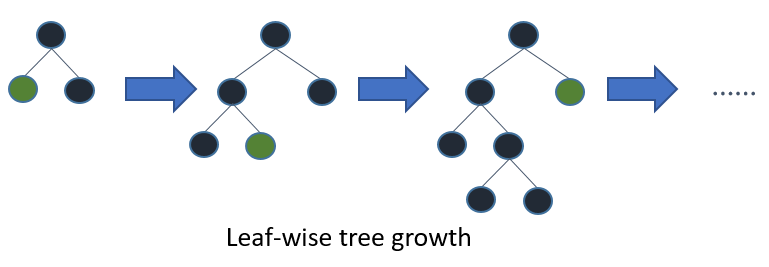

Ao utilizar a biblioteca do lightgbm ([documentação](https://lightgbm.readthedocs.io/en/latest/index.html)), existem duas escolhas a serem feitas: utilizar a API de treino ou a API do scikit-learn. Ambas as APIs geram os mesmos resultados se possuírem as mesmas configurações.

Para simplificar a criação do modelo, neste trabalho, optou-se por utilizar a API de treino, já que facilita a utilização do *early stop* quando utilizamos função de validação cruzada. A desvantagem é que dificulta a otimização de hiper-parâmetros para a melhoria do modelo, contudo, devido ao esforço computacional elevado, não realizaremos essa etapa.


Para iniciar o modelo, devemos retirar as colunas de pickup_datetime, key e as que relacionam o preço com a distância percorrida.

In [ ]:
y = X.fare_amount.copy()
key = X_test.key.copy()
X_test.drop(['pickup_datetime','key'] ,axis = 1, inplace=True)

X_train = X[X_test.columns]

Em seguida, definiremos o modelo, implementaremos a validação cruzada e realizaremos a predição das variáveis de teste. é necessário configurar os parâmetros do modelo. Aqui, utilizaremos a seguinte configuração:

* *boosting_type*: default (gradient boosting)
* *objective*: regressão linear
* *metric*: rmse (root mean squared error) - utilizado para a submissão final do arquivo
* *num_boost_round*: utilizaremos um valor alto (1000). Contudo, também colocaremos um valor mais baixo para o *early_stopping_rounds*, logo, esse número de rounds não será alcançado
* *early_stopping_rounds*: utilizaremos o valor de 125. Ou seja, passadas 125 épocas de treinamento sem alteração do valor do rmse, o treinamento será terminado
* *verbose_eval*: 250. Esse valor indica a cada quantas épocas de treinamento deve-se printar o valor do rmse do conjunto de validação


In [ ]:
# Iniciando um objeto de dataset de lgb
dtrain = lgb.Dataset(X_train, label=y, free_raw_data=False)

# Iniciando a quantiadade de folds para a validação cruzada 
folds = KFold(n_splits=5, shuffle=True, random_state=1)

# A variável predictions possuirá o valor final das predições para o conjunto de testes
predictions = np.zeros(X_test.shape[0])
params =  {'task': 'train', 'boosting_type': 'gbdt','objective': 'regression','metric': 'rmse'}

# Variável que vai guardar o valor do rmse de validação a cada época de treinamento
evals_result = {}

# Realização do treinamento e predição
for train_index, validation_index in folds.split(X_train):
    clf = lgb.train(
        params=params,
        train_set=dtrain.subset(train_index),
        valid_sets=dtrain.subset(validation_index),
        num_boost_round=1000, 
        early_stopping_rounds=125,
        evals_result=evals_result,
        verbose_eval=250
    )
    predictions = predictions + clf.predict(X_test) / folds.n_splits



Em seguida, devemos refazer o datframe de submissão com o valor das predições adquiridos.

In [ ]:
# Dataframe de submissão
submission = pd.DataFrame(predictions,columns=["fare_amount"],index=X_test.index)

# Colocando de volta a coluna key
keys = pd.DataFrame(key, columns = ['key'], index=  X_test.index)
submission = pd.concat([keys, submission], axis = 1)

# Valores iniciais das predições
submission.head()


In [ ]:
submission.to_csv('submit.csv', index = False)

Por fim, podemos visualizar a diminuição do rmse ao longo das iterações de treinamento. Além disso, também visualizamos as variáveis de maior importância para a construção do modelo final.

In [ ]:
lgb.plot_metric(evals_result)
plt.show()

In [ ]:
lgb.plot_importance(clf)
plt.show()

# **5. Conclusões**

* Após realizar a modelagem com o LGBM e a submissão do conjunto de dados de teste, obteve-se um rmse de 3.44801, classificando-se na posição 640 do quadro de líderes. Alguma reflexões acerca do trabalho, bem como possíveis melhorias são indicadas a seguir.

* Conforme pôde ser observado na exploração de dados, algumas variáveis foram mantidas mesmo não apresentando uma correlação tão forte com a *label*. Para simplificar ainda mais o modelo, poderíamos retirar o número de passageiros, por exemplo.

* O algoritmo implementado pelo LGBM realiza a bucketização de variáveis contínuas na tentativa de encontrar os melhores split points. Pelos resultados do modelo, pudemos observar que as coordenadas geográficas acabaram tendo um peso mais forte do que as zonas de clusterização desenvolvidas. Como procedimentos alternativos, poderíamos diminuir a quantidade de clusters ou mudar o modelo utilizado. Algoritmos de regressão linear não baseados em árvores poderiam ser testados.

* Um dos fatores que parece mais afetar a qualidade do modelo desenvolvido é o tratamento das variáveis mais simples: a distância da viagem, os limites aplicados à cidade de Nova Iorque e o preço final da viagem. Nesse sentido, poderíamos realizar uma limpeza mais intesiva, diminuindo o threshold para retirada dos outliers (seção 3.1 e 3.2).

* Conforme observado no documento do governo de Nova Iorque que rege o preço das viagens, o tempo da viagem também afeta o preço. Infelizmente não temos tal variável fornecida no conjunto de dados. Contudo, poderíamos realizar estimações do tempo da viagem baseado no trânsito no local em que a viagem ocorreu. Para isso, poderíamos calcular a densidade de viagens acontecendo ao mesmo tempo em lugares próximos.

* A distância da viagem é uma das *features* mais importantes criadas. Contudo, essa não reflete precisamente a distância percorrida pelo veículo, já que não leva em consideração as ruas que foram trafegadas para chegar ao destino. É possível utilizar bibliotecas que permitem a realização desse cálculo, o que provavelmente melhoraria o desempenho do modelo.